In [1]:
import numpy as np
import pandas as pd

In [2]:
data_directory = '/home/mytrah-pc/Data/Burgula_extract/B-525[20160512-231000][20170607-144000].csv'
file_name = ''
file_path = data_directory + file_name
turbine_state = 100

data_set = pd.read_csv(file_path)[['Timestamp', 'WindSpeed', 'ActivePower', 'TurbineState']]
data_set = data_set[data_set['ActivePower'] > 0]
data_set = data_set[data_set['TurbineState'] == turbine_state]
min_WindSpeed = data_set['WindSpeed'].min()
min_ActivePower = data_set['ActivePower'].min()
normalize_WindSpeed_factor = data_set['WindSpeed'].max() - min_WindSpeed
normalize_ActivePower_factor = data_set['ActivePower'].max() - min_ActivePower
data_set['scaled_WindSpeed'] = ((data_set['WindSpeed'] - min_WindSpeed) * 100 / normalize_WindSpeed_factor)
data_set['scaled_ActivePower'] = ((data_set['ActivePower'] - min_ActivePower) * 100 / normalize_ActivePower_factor)

def rounding_method(multiply_factor, round_off_by_factor):
    return lambda number: int(number * multiply_factor) + round_off_by_factor - int(number * multiply_factor) % round_off_by_factor

data_set['discrete_ActivePower'] = data_set['scaled_ActivePower'].apply(rounding_method(1, 2))
data_set.index = pd.to_datetime(data_set['Timestamp'])
del data_set['Timestamp']

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.scatter(data_set['scaled_WindSpeed'], data_set['discrete_ActivePower'])

In [4]:
from sklearn.cluster import KMeans, DBSCAN
n_kmeans_clusters = 14
kmeans_alg_obj = KMeans(n_clusters=n_kmeans_clusters)
dbscan_alg_obj = DBSCAN(eps=0.7, min_samples=1)
previous_width = -1
threshold_width_deviation = 1.8
allowed_width_deviation = threshold_width_deviation
epsilon_deviation = 0.33
change_width_for = {}
weight_min_width = 0.9
weight_max_width = 0.1
weight_max_deviation = 0.6
weight_min_deviation = 0.4
allowed_group_wind_speed_deviation = 0.13
min_points_in_group = 4
limit_elements_in_group_std = 1.6
limit_next_center_std = 0.5
right_diff_limit = 5

for group in data_set.groupby('discrete_ActivePower'):

    work_group = group[1].copy()
    work_group['dbscan_label'] = dbscan_alg_obj.fit_predict(work_group[['scaled_WindSpeed', 'discrete_ActivePower']])
    work_group = work_group[work_group['dbscan_label'] != -1].copy()

    if work_group.shape[0] <= n_kmeans_clusters:
        continue


    kmeans_alg_obj.fit(work_group[['scaled_WindSpeed', 'discrete_ActivePower']])
    work_group['kmeans_label'] = kmeans_alg_obj.labels_
    label_positions = [i[0] for i in sorted(enumerate(kmeans_alg_obj.cluster_centers_[:,0]), key=lambda x:x[1])]
    sorted_values = np.sort(kmeans_alg_obj.cluster_centers_[:,0], axis=0)
    current_width = sorted_values[-1] - sorted_values[0]

    for grp in work_group.groupby('dbscan_label'):
        plt.scatter(grp[1]['scaled_WindSpeed'], grp[1]['discrete_ActivePower'])



    if previous_width == -1:
        previous_width = current_width
        continue

    if np.std([previous_width, current_width]) < allowed_width_deviation:
        allowed_width_deviation = weight_min_deviation * np.min([(np.std([previous_width, current_width]) + epsilon_deviation), threshold_width_deviation]) \
                                + weight_max_deviation * np.max([(np.std([previous_width, current_width]) + epsilon_deviation), threshold_width_deviation])
        plt.scatter(work_group['scaled_WindSpeed'].min(), group[0], c='#ff0000')
        plt.scatter(work_group['scaled_WindSpeed'].max(), group[0], c='#ff0000')
        previous_width = weight_min_width * np.min([previous_width, current_width]) + weight_max_width * np.max([previous_width, current_width])

        if group[0] > 60 and group[0] < 65:
            print group[0], previous_width, current_width, np.std([previous_width, current_width])

        continue

    m = 0
    n = -1

    if group[0] > 60 and group[0] < 65:
        print sorted_values

    while (np.std([previous_width, current_width]) > allowed_width_deviation) and (current_width > previous_width):
        _group_kmeans_filter_m = work_group[work_group['kmeans_label'] == label_positions[m]]

        if ((n < -(n_kmeans_clusters - 2))
                or (((np.std(_group_kmeans_filter_m['scaled_WindSpeed']) < allowed_group_wind_speed_deviation)
                        or (_group_kmeans_filter_m.shape[0] < min_points_in_group))
                    and np.std([sorted_values[m], sorted_values[m + 1]]) > limit_next_center_std)):
            m = m + 1
            n = -1

        if ((np.std(_group_kmeans_filter_m['scaled_WindSpeed']) > limit_elements_in_group_std) 
                and (work_group[work_group['kmeans_label'] == label_positions[m]].shape[0] < min_points_in_group)):
            n = m
            break

        if m > (n_kmeans_clusters - 2):
            m = 0
            n = -1
            break

        n = n - 1
        current_width = sorted_values[n] - sorted_values[m]


    change_width_for[group[0]] = {}
    left_most = work_group[work_group['kmeans_label'] == label_positions[m]]['scaled_WindSpeed'].min()
    right_most = work_group[work_group['kmeans_label'] == label_positions[n]]['scaled_WindSpeed'].max()

    current_width = right_most - left_most

    change_width_for[group[0]]['l'] = left_most
    change_width_for[group[0]]['r'] = right_most
    previous_width = weight_min_width * np.min([previous_width, current_width]) + weight_max_width * np.max([previous_width, current_width])
    if group[0] > 60 and group[0] < 65:
        print group[0], m, n, previous_width, current_width, np.std([previous_width, current_width])

    m = 0
    n = -1

for x in change_width_for.keys():
    plt.scatter(change_width_for[x]['l'], x, c='#000000')
    plt.scatter(change_width_for[x]['r'], x, c='#000000')

62 3.93583559739 6.65616891109 1.36016665685
[ 41.58497524  42.51182244  43.31314369  45.01044577  46.06009794
  47.80370797  47.92721714  48.21657451  48.43665077  48.79778178
  48.92847149  49.08486277  49.85394422  50.68221853]
64 0 -3 4.29401539622 7.51763358571 1.61180909474


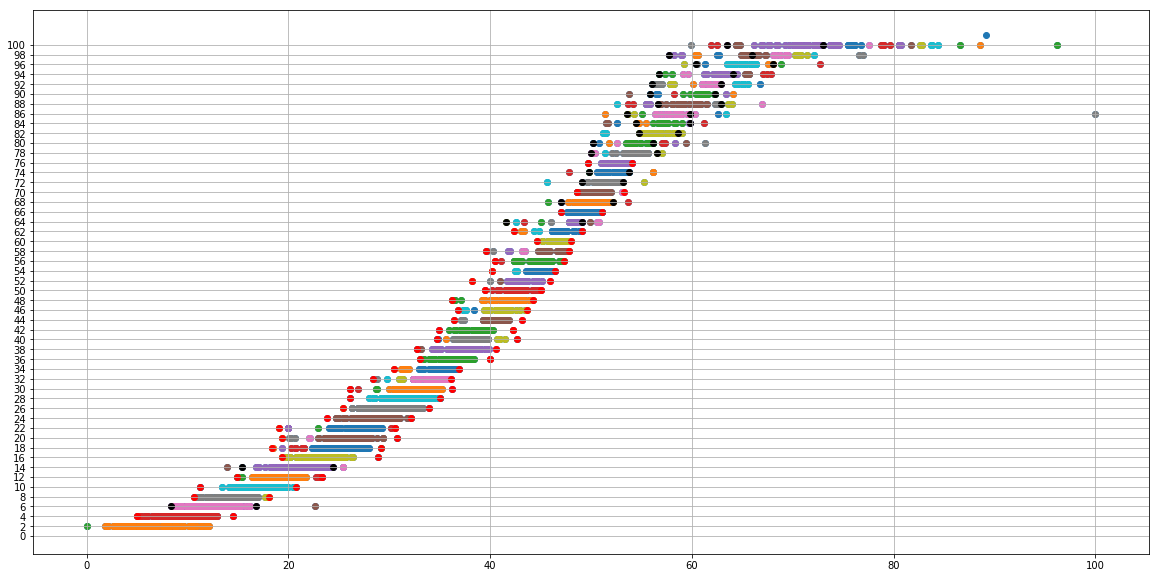

In [5]:
plt.yticks(np.arange(0, 102, 2))
plt.grid(True)
plt.show()